# Load Model

In [1]:
import openvino as ov

core = ov.Core()

model = core.read_model(model='models/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model = model, device_name="CPU")


input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

print("input_shape:", input_layer.shape)
print("output_shape:", output_layer.shape)

input_shape: [1,3,384,672]
output_shape: [1,1,200,7]


# Pre-Process New Input Data

### Call Image

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/people.jpg")
print(image.shape)
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels=image.shape
image = cv2.resize(image, (int(image_width/5), int(image_width/5)))
print(image.shape)

cv2.imshow("image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(4000, 4684, 3)
(936, 936, 3)


# Preprocess Data

In [3]:
import numpy as np 
def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2,0,1)
    input_image = np.expand_dims(transposed_image, 0)

    return input_image

In [4]:
input_image = preprocess(image)

print(image.shape)
print(input_image.shape)

(936, 936, 3)
(1, 3, 384, 672)


# Run Interface

In [5]:
results = compiled_model([input_image])[output_layer]

In [6]:
print(results.shape)

(1, 1, 200, 7)


In [7]:
results = np.squeeze(results)
print(np.shape(results))
print(results)

#print(results[0])

#print(np.round(results[0],2))

#print(results[0][0][-1])

(200, 7)
[[0.         1.         0.99953973 ... 0.1184392  0.70465064 0.83538735]
 [0.         1.         0.03067586 ... 0.35257766 0.966439   0.43015864]
 [0.         1.         0.02811646 ... 0.3020833  0.9723709  0.40996695]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Postprocess

In [8]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:,2]
    boxes = results[:,-4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >=confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [9]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[256 110 659 781]]


In [10]:
#loop

for i in range(len(face_boxes)):
    print(face_boxes[i])
    print(scores[i])

[256 110 659 781]
0.99953973


In [11]:
print(len(face_boxes))

1


In [13]:
print(scores)

[0.99953973]


In [15]:
def draw_faceboxes(images, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)): 

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img = show_image, pt1=(xmin,ymin),pt2=(xmax,ymax),
                      color=(0,200,0), thickness=2)

    return show_image

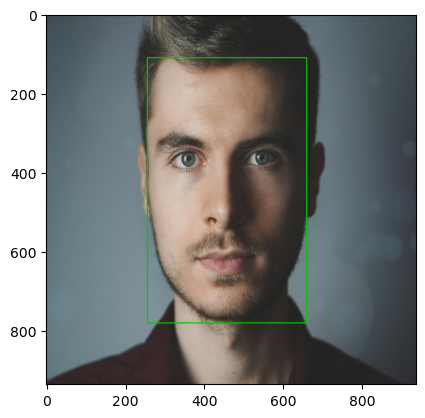

In [16]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [17]:
cv2.imshow("image", show_image)
cv2.waitKey()
cv2.destroyAllWindows()